<a href="https://colab.research.google.com/github/Rekt77/kisa_insuretech/blob/master/kisa_insure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize
from wordcloud import WordCloud, STOPWORDS

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_excel("/content/drive/My Drive/insuretech/insurance/kisa_insurance.xlsx")

In [0]:
new_columns = ['c_idx','s_idx','sex','age','occupation','middle_div','small_div','sub_div','city','district','ins_cat','ins_name','gar_name','long_gar_cat','sp_term']
df.columns = new_columns
df.head()

,c_idx,s_idx,sex,age,occupation,middle_div,small_div,sub_div,city,district,ins_cat,ins_name,gar_name,long_gar_cat,sp_term
0,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해후유장해,교통상해50%이상후유장해(1회한)
1,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,행정소송법률비용손해(실손)
2,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,상해사망
3,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,교통상해사망
4,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,법률비용손해(실손)


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103234 entries, 0 to 103233
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   c_idx         103234 non-null  int64 
 1   s_idx         103234 non-null  int64 
 2   sex           103234 non-null  object
 3   age           103234 non-null  int64 
 4   occupation    103234 non-null  object
 5   middle_div    103234 non-null  object
 6   small_div     103234 non-null  object
 7   sub_div       103234 non-null  object
 8   city          103234 non-null  object
 9   district      103234 non-null  object
 10  ins_cat       103234 non-null  object
 11  ins_name      103234 non-null  object
 12  gar_name      101472 non-null  object
 13  long_gar_cat  103234 non-null  object
 14  sp_term       103234 non-null  object
dtypes: int64(3), object(12)
memory usage: 11.8+ MB


In [0]:
def eng_sex(x):
  if x == "남자":
    return 0
  else:
    return 1

def ageCategorize(x):
  return str(x//10*10)

pop_age = df.loc[:,["sex","age"]]
pop_age["eng_sex"] = pop_age["sex"].apply(eng_sex)
pop_age["age_catgorized"] = pop_age["age"].apply(ageCategorize)

pop_age.head()

,sex,age,eng_sex,age_catgorized
0,여자,21,1,20
1,여자,21,1,20
2,여자,21,1,20
3,여자,21,1,20
4,여자,21,1,20


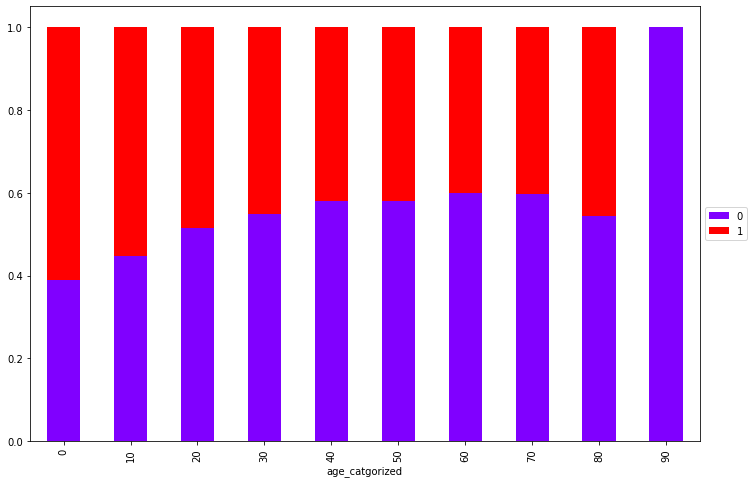

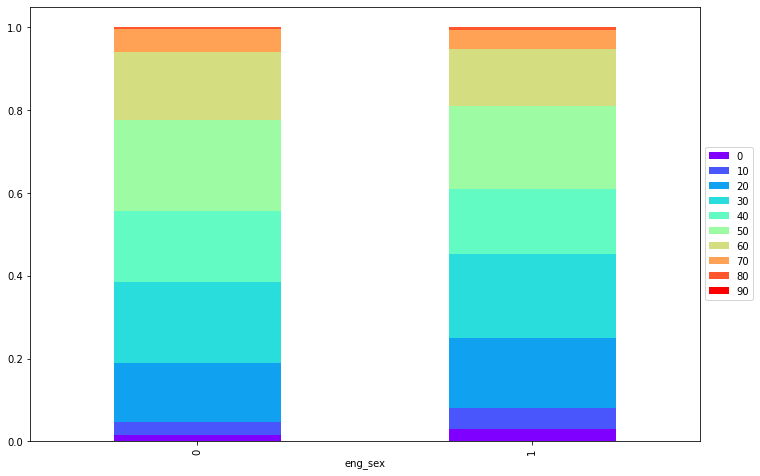

In [0]:
ctab_age = pd.crosstab(pop_age['age_catgorized'],
                     pop_age['eng_sex']).apply(lambda x: x/x.sum(), axis=1)

ctab_age.plot(kind='bar',
            stacked=True,
            colormap='rainbow',
            figsize=(12,8)).legend(loc='center left',
                                   bbox_to_anchor=(1, 0.5))
            
ctab_sex = pd.crosstab(pop_age['eng_sex'],
                     pop_age['age_catgorized']).apply(lambda x: x/x.sum(), axis=1)

ctab_sex.plot(kind='bar',
            stacked=True,
            colormap='rainbow',
            figsize=(12,8)).legend(loc='center left',
                                   bbox_to_anchor=(1, 0.5))

In [0]:
from collections import Counter

pop_job = df.loc[:,["occupation","age","sex"]]

job_freq = Counter(pop_job["occupation"])
job_map = {k:i for i,k in enumerate(job_freq.keys())}
pop_job["occupation_mapped"] = pop_job["occupation"].replace(job_map)

# value count
pop_job_counts = pop_job.groupby("occupation_mapped",as_index=False).count().sort_values("occupation",ascending=False)

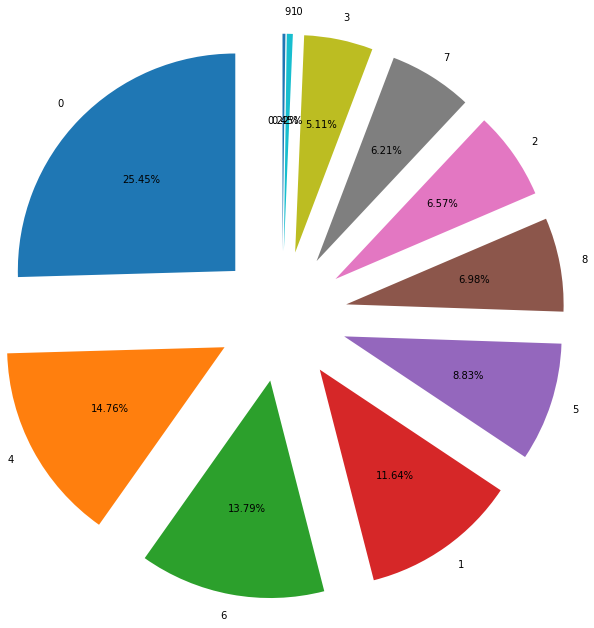

In [0]:
plt.figure(figsize=(20,10))
plt.pie(
    x="occupation",
    data=pop_job_counts,
    labels=pop_job_counts["occupation_mapped"],
    autopct='%1.2f%%', # second decimal place
    startangle=90,
    explode=[0.3 for _ in range(11)]
)
plt.show()

1.Feature
 - SEX
   - 남자 : 0
   - 여자 : 1

In [0]:
sex_map = {"남자":0,"여자":1}

df["sex"] = df["sex"].replace(sex_map)
df.head()

,c_idx,s_idx,sex,age,occupation,middle_div,small_div,sub_div,city,district,ins_cat,ins_name,gar_name,long_gar_cat,sp_term
0,2,26394,1,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해후유장해,교통상해50%이상후유장해(1회한)
1,2,26394,1,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,행정소송법률비용손해(실손)
2,2,26394,1,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,상해사망
3,2,26394,1,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,교통상해사망
4,2,26394,1,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,법률비용손해(실손)


 - occupation
  - 직업 군
  - 상세직업(중,소,세)는 결측치가 너무 많고 대체값이 존재하지 않기 때문에 열 삭제
  --------------
   * 주부, 학생 및 기타 비경제활동인구': 0,
   * 자연과학, 공학, 컴퓨터 및 통신 관련분야': 1,
   * 서비스 관련 분야 (음식, 숙박, 여행 등)': 2,
   * 농림어업, 광업, 축산업 관련 분야': 3,
   * 교육, 의료, 종교, 문화예술, 스포츠, 사회복지 관련 분야': 4,
   * 화학, 섬유, 식품, 설비 및 기타 제조 (기능, 생산직 관련 분야)': 5
   * 행정, 금융, 사무관리,법률 관련 분야': 6,
   * 전기, 전자, 기계, 금속 (기능, 생산직 관련 분야)': 7,
   * 판매 관련 분야': 8,
   * 건설, 운송(기능직 관련분야)': 9,
   * 군인,경찰, 경호, 소방, 경비 관련 분야': 10,
   
   

In [0]:
import collections

df = df.drop(columns=['middle_div','small_div','sub_div'])

In [0]:
bow = collections.Counter(df['occupation'])

occp_map = { k:i for i,k in enumerate(bow.keys()) }
df['occupation'] = df['occupation'].replace(occp_map)
df.head()

,c_idx,s_idx,sex,age,occupation,city,district,ins_cat,ins_name,gar_name,long_gar_cat,sp_term
0,2,26394,1,21,0,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해후유장해,교통상해50%이상후유장해(1회한)
1,2,26394,1,21,0,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,행정소송법률비용손해(실손)
2,2,26394,1,21,0,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,상해사망
3,2,26394,1,21,0,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,교통상해사망
4,2,26394,1,21,0,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,법률비용손해(실손)


- age
 - child, young, adult, mid-age, senior 로 구분
 - child -> 고등학생 이전(~16세)
 - young -> 대학교졸업(17~26세)
 - adult -> 사회초년생 -> 과장급(27~36세)
 - mid-age -> 예상 은퇴 나이(37~57세)
 - senior -> 퇴직이후(58세~)

In [0]:
age_map = {'child':0,'young':1,'adult':2,'mid-age':3,'senior':4}
df.loc[df["age"] <= 20, 'age'] = 0
df.loc[(df["age"] > 20) & (df["age"] <= 30), 'age'] = 1
df.loc[(df["age"] > 30) & (df["age"] <= 40), 'age'] = 2
df.loc[(df["age"] > 40) & (df["age"] <= 50), 'age'] = 3
df.loc[(df["age"] > 50) & (df["age"] <= 60), 'age'] = 4
df.loc[(df["age"] > 60), 'age'] = 5

df["age"].value_counts()

4    21829
2    19670
5    19175
3    17964
1    17455
0     7141
Name: age, dtype: int64


# https://data.seoul.go.kr/dataList/11043/S/2/datasetView.do

- city-district
 - 전부 서울에 살고 있으므로 city는 제외
 - 사는 지역에서 차별점이 있는 변수는 자본수준(gdp로 측정)
 - district를 gdp//100000한 값으로 대체
 - MinMax scaler를 통해서 0~5 사이의 값으로 스케일링

In [0]:
df = df.drop(columns="city")
with open("/content/drive/My Drive/insuretech/insurance/report.txt","r") as f:
  rows = f.read().split("\n")
city_gdp_map = {each.split("\t")[1]:int(each.split("\t")[2].replace(",",""))//100000 for each in rows[1:]}
df["district"] = df["district"].replace(city_gdp_map)
df.head(10)

,c_idx,s_idx,sex,age,occupation,district,ins_cat,ins_name,gar_name,long_gar_cat,sp_term
0,2,26394,1,1,0,52,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해후유장해,교통상해50%이상후유장해(1회한)
1,2,26394,1,1,0,52,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,행정소송법률비용손해(실손)
2,2,26394,1,1,0,52,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,상해사망
3,2,26394,1,1,0,52,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,교통상해사망
4,2,26394,1,1,0,52,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,법률비용손해(실손)
5,2,26394,1,1,0,52,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,운전중손해,상해기타,자동차부상치료비(1~5급)
6,4,20024,0,1,0,28,장기/질병,무배당 프로미라이프 참좋은치아사랑보험1904,질병,질병기타,치주질환치료비(20년만기자동갱신)
7,4,20024,0,1,0,28,장기/질병,무배당 프로미라이프 참좋은치아사랑보험1904,질병,질병기타,특정치석제거(스케일링)치료비(20년만기자동갱신)
8,4,20024,0,1,0,28,장기/질병,무배당 프로미라이프 참좋은치아사랑보험1904,질병,질병기타,"치아치수치료비(상해및질병)(유치,영구치)(20년만기자동갱신)"
9,4,20024,0,1,0,28,장기/질병,무배당 프로미라이프 참좋은치아사랑보험1904,상해,질병기타,영구치보철치료비(상해및질병)(20년만기자동갱신)


In [0]:
MAX = df["district"].max()
MIN = df["district"].min()
denom = MAX-MIN

def scaler(denom,min,x):
    return (x - min) / denom

df["district"] = df["district"].apply(lambda x: scaler(denom,MIN,x))
df["district"].value_counts()

0.042032    10315
0.000000     8681
0.080560     7909
0.138354     7281
0.043783     6060
0.159370     6015
0.056042     5425
0.336252     5330
0.021016     5010
0.019264     4591
0.075306     4181
1.000000     4167
0.436077     4145
0.213660     3854
0.040280     3462
0.054291     3402
0.236427     3211
0.134851     2735
0.465849     2644
0.131349     1795
0.441331     1621
0.802102     1400
Name: district, dtype: int64

In [0]:
df.head()

,c_idx,s_idx,sex,age,occupation,district,ins_cat,ins_name,gar_name,long_gar_cat,sp_term
0,2,26394,1,1,0,0.042032,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해후유장해,교통상해50%이상후유장해(1회한)
1,2,26394,1,1,0,0.042032,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,행정소송법률비용손해(실손)
2,2,26394,1,1,0,0.042032,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,상해사망
3,2,26394,1,1,0,0.042032,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,교통상해사망
4,2,26394,1,1,0,0.042032,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,법률비용손해(실손)


- ins_cat

In [0]:
df["ins_cat"].value_counts()
ins_cat_map = dict(zip(["장기/질병","장기/운전자","장기/상해","장기/재물","장기/저축"],np.linspace(0,4,5)))
df["ins_cat"] = df["ins_cat"].replace(ins_cat_map)
df["ins_cat"].value_counts()

0.0    43236
1.0    34976
2.0    24742
3.0      270
4.0       10
Name: ins_cat, dtype: int64

- ins_name
 - 총 56개의 보험중 상위 10개 제외 나머지 삭제

In [0]:
df = df.loc[df["ins_name"].isin(df["ins_name"].value_counts().index[:10])]

- long_gar_cat&sp_term
 - 보험 가입 시 증권번호가 생성되고 고객번호랑은 별개
 - 같은 고객이 여러개의 보험을 가입했을 경우가 있으므로 증권번호를 기준으로 데이터를 정제
 - 증권번호별 보험당 특약개수를 종합

In [0]:
sidxs = df["s_idx"].drop_duplicates()
for sidx in sidxs:
  df.loc[df["s_idx"]==sidx,"gar_name"] = sum(collections.Counter(df.loc[df["s_idx"]==sidx]["ins_name"]).values())

MAX = df["gar_name"].max()
MIN = df["gar_name"].min()
denom = MAX-MIN

df["gar_name"] = df["gar_name"].apply(lambda x: scaler(denom,MIN,x)*4)

In [0]:
pop_col = ["c_idx","s_idx","sex","age","occupation","district","ins_cat","ins_name","gar_name"]
pop_df = df[pop_col].drop_duplicates()
pop_df.columns = ["c_idx","s_idx","sex","age","occupation","gdp","ins_cat","ins_name","gar_count"]
pop_df.head()

,c_idx,s_idx,sex,age,occupation,gdp,ins_cat,ins_name,gar_count
0,2,26394,1,1,0,0.042032,1.0,무배당 프로미라이프 참좋은운전자+보험1908,0.173913
13,8,27841,0,1,0,0.075306,0.0,무배당 프로미라이프 참좋은행복플러스+종합보험1911,0.800000
37,15,16512,0,0,0,0.213660,1.0,무배당 프로미라이프 참좋은운전자+보험1908,0.313043
47,21,27840,1,0,0,0.075306,2.0,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,0.765217
70,25,14177,0,0,0,0.159370,2.0,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,1.252174


In [0]:
# 0번 직업군에 가까울 수록 보험 특약이 많음
pd.crosstab(pop_df["occupation"],pop_df["gar_count"]).sum(axis=1)

occupation
0     1281
1      568
2      331
3      273
4      680
5      449
6      694
7      310
8      346
9       11
10      20
dtype: int64

In [0]:
# district-occupation
pivot = pd.crosstab(pop_df["gdp"],pop_df["occupation"])

# 전체 비율대비로 확인
SUM = pop_df["gdp"].value_counts().sum()
rat = pop_df["gdp"].value_counts()/SUM
pivot.div(rat,axis=0)

occupation,0,1,2,3,4,5,6,7,8,9,10
0.000000,1231.513648,492.605459,406.399504,455.660050,529.550868,480.290323,578.811414,443.344913,307.878412,0.000000,36.945409
0.019264,1430.774775,491.828829,335.337838,245.914414,737.743243,536.540541,603.608108,245.914414,268.270270,44.711712,22.355856
0.021016,1235.685714,526.685714,506.428571,222.828571,405.142857,546.942857,709.000000,465.914286,344.371429,0.000000,0.000000
0.040280,1072.253086,459.537037,275.722222,183.814815,949.709877,367.629630,673.987654,490.172840,490.172840,0.000000,0.000000
0.042032,1610.442857,546.942857,324.114286,141.800000,627.971429,476.042857,658.357143,263.342857,273.471429,30.385714,10.128571
0.043783,1179.152482,563.177305,316.787234,228.790780,809.567376,404.783688,580.776596,334.386525,492.780142,0.000000,52.797872
0.054291,1347.569536,460.145695,525.880795,262.940397,624.483444,394.410596,690.218543,394.410596,197.205298,0.000000,65.735099
0.056042,1298.015385,553.565385,286.326923,209.973077,591.742308,649.007692,839.892308,190.884615,305.415385,0.000000,38.176923
0.075306,1399.143617,395.984043,369.585106,343.186170,818.367021,501.579787,712.771277,79.196809,290.388298,52.797872,0.000000
0.080560,1208.935897,674.458974,407.220513,356.317949,470.848718,432.671795,674.458974,305.415385,419.946154,0.000000,12.725641


In [0]:
# 질병,운전자,상해가 비슷한 특약 양상을 보임
pivot = pd.crosstab(pop_df["ins_cat"],pop_df["gar_count"]).sum(axis=1)

- randomforest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [0]:
pop_df = shuffle(pop_df)
data = pop_df.drop(['c_idx','s_idx','ins_name'], axis=1)
label = pop_df["ins_name"]

train_data, test_data, train_label, test_label = train_test_split(data,label)

train_data.to_excel("/content/drive/My Drive/insuretech/train_data.xlsx")
test_data.to_excel("/content/drive/My Drive/insuretech/test_data.xlsx")

train_label.to_excel("/content/drive/My Drive/insuretech/train_label.xlsx")
test_label.to_excel("/content/drive/My Drive/insuretech/test_label.xlsx")


In [0]:
test_data.head()
pd.crosstab(pop_df["age"],pop_df["ins_cat"])

ins_cat,0.0,1.0,2.0
age,,,
0,14,4,295
1,132,212,423
2,333,292,263
3,314,361,169
4,406,467,240
5,319,565,154


In [0]:
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_data,train_label)
pre = clf.predict(test_data)
report = metrics.classification_report(pre,test_label)
print(report)

                                  precision    recall  f1-score   support

   무배당 프로미라이프 실손의료비보험(계약전환용)2001       0.44      0.61      0.51        33
          무배당 프로미라이프 실손의료비보험2001       0.91      0.89      0.90       210
무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001       1.00      0.92      0.96       105
  무배당 프로미라이프 참좋은 훼밀리플러스+종합보험1911       0.31      0.39      0.35       102
        무배당 프로미라이프 참좋은간편건강보험1906       0.65      0.63      0.64       131
       무배당 프로미라이프 참좋은상해보험1908_TM       0.89      0.94      0.91        17
        무배당 프로미라이프 참좋은운전자+보험1908       0.88      0.79      0.83       408
     무배당 프로미라이프 참좋은운전자보험(TM)1908       0.17      0.30      0.22        61
    무배당 프로미라이프 참좋은행복플러스+종합보험1911       0.52      0.43      0.47       171
 무배당 프로미라이프 처음약속 100세까지 종합보험1911       0.00      0.00      0.00         3

                        accuracy                           0.69      1241
                       macro avg       0.58      0.59      0.58      1241
                    weighted avg    